# 라이브러리 & 데이터 불러오기

In [101]:
import pandas as pd
import os

In [102]:
os.chdir(r'C:\Users\User\LearningSpoons\파이썬 포트폴리오\프로젝트 3. Home Credit 대출상환여부 예측\data')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
lb = pd.read_csv('loan_before.csv')

In [103]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [104]:
lb.columns

Index(['SK_ID_CURR', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'CREDIT_TYPE'],
      dtype='object')

# 1. 문제정의
질문 1 - 어떤 요소가 대출금 상환 여부에 큰 영향을 줄까?  
질문 2 - 그 요소들이 상환여부에 어떤 영향을 줄까?

# 2. 방법론
## 2.1 분석과정
이 질문에 대한 해답을 얻기 위해서 해석가능한 머신러닝(XAI)을 활용하였다.

프로세스  

1단계 : feature engineering을 한다.    
2단계 : 머신러닝 모델을 만든다.  
3단계 : shap value를 통해 어떤 변수가 가장 큰 영향을 주는지 알아본다.  
4단계 : 영향을 많이 주는 5개의 변수와 대출금 상환 여부와의 관계를 살펴본다.

## 2.2 feature engineering
AMT_CREDIT에서 AMT_ANNUITY를 나누어 해당 사람이 몇개월에 걸쳐 돈을 갚아야 하는지 변수화하였다.




In [105]:
#새로운 변수 생성
train['AMT_CREDIT_TO_ANNUITY_RATIO'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']
test['AMT_CREDIT_TO_ANNUITY_RATIO'] = test['AMT_CREDIT'] / test['AMT_ANNUITY']

lb(이전에 대출한 정보가 기록된 데이터)를 활용해 변수생성을 시도한다.

**1. groupby 후 평균(사람 id로 묶은 후 각 변수를 평균을 낸다)**

AMT_CREDIT_SUM(이전 대출의 금액)  
DAYS_CREDIT(train,test로부터 며칠 전에 이전 대출을 진행했는지)  
CNT_CREDIT_PROLONG(대출연장을 몇 번 했는지)

**2. groupby 후 갯수(사람 id별로의 빈도수, 해당 사람이 이전에 대출을 몇 번 진행했는지)**

In [106]:
#새로운 변수 생성
train = pd.merge( train, lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index(), on='SK_ID_CURR', how='left')
test = pd.merge( test, lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index(), on='SK_ID_CURR', how='left')

train = pd.merge( train, lb.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].mean().reset_index(), on='SK_ID_CURR', how='left')
test = pd.merge( test, lb.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].mean().reset_index(), on='SK_ID_CURR', how='left')

train = pd.merge( train, lb.groupby(['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index(), on='SK_ID_CURR', how='left')
test = pd.merge( test, lb.groupby(['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index(), on='SK_ID_CURR', how='left')

In [107]:
train = pd.merge(train , lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns={0:'count'}),on='SK_ID_CURR', how='left')
test = pd.merge(test , lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns={0:'count'}),on='SK_ID_CURR', how='left')

In [108]:
# 변수가 생성되었는지 확인
train.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,...,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_TO_ANNUITY_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,count
0,162716,0,0.0,0,1,0,101250.0,480060.0,22509.0,Unaccompanied,...,NaN,0.665732,NaN,-139.0,1.0,21.327469,3.150000e+05,-36.000000,0.0,1.0
1,361317,0,0.0,0,1,2,225000.0,237024.0,12231.0,Unaccompanied,...,0.575699,0.535140,0.670652,-957.0,0.0,19.378955,2.067966e+06,-1408.000000,0.0,9.0
2,246925,0,1.0,0,0,0,171000.0,247675.5,26005.5,Unaccompanied,...,0.092273,0.002272,0.154744,-827.0,1.0,9.523966,6.219386e+04,-597.142857,0.0,7.0
3,294331,0,1.0,1,0,0,225000.0,180000.0,9000.0,Unaccompanied,...,0.221815,0.120444,NaN,-569.0,2.0,20.000000,2.770443e+04,-1545.000000,0.0,1.0
4,152173,0,0.0,0,1,0,180000.0,337500.0,12852.0,Unaccompanied,...,NaN,0.722415,0.723837,-1544.0,4.0,26.260504,1.068750e+05,-2696.000000,0.0,1.0


In [109]:
#컬럼별 데이터 타입 살펴보기
train.dtypes

SK_ID_CURR                       int64
TARGET                           int64
CODE_GENDER                    float64
FLAG_OWN_CAR                     int64
FLAG_OWN_REALTY                  int64
CNT_CHILDREN                     int64
AMT_INCOME_TOTAL               float64
AMT_CREDIT                     float64
AMT_ANNUITY                    float64
NAME_TYPE_SUITE                 object
NAME_INCOME_TYPE                object
NAME_EDUCATION_TYPE             object
NAME_HOUSING_TYPE               object
REGION_POPULATION_RELATIVE     float64
DAYS_BIRTH                       int64
DAYS_EMPLOYED                  float64
DAYS_ID_PUBLISH                  int64
OWN_CAR_AGE                    float64
CNT_FAM_MEMBERS                float64
HOUR_APPR_PROCESS_START          int64
ORGANIZATION_TYPE               object
EXT_SOURCE_1                   float64
EXT_SOURCE_2                   float64
EXT_SOURCE_3                   float64
DAYS_LAST_PHONE_CHANGE         float64
AMT_REQ_CREDIT_BUREAU_YEA

**이 프로젝트의 목적은 모델 해석이기 때문에 방해를 주는 요소는 제거함.**

shap value는 범주형변수가 독립변수 일때 해석하기 어려움  
범주형 아니더라도 범주의 의미가지면 어려워져서 제거하고 사용하는게 좋음

CODE_GENDER, FLAG_OWN_CAR, NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,  
NAME_HOUSING_TYPE,ORGANIZATION_TYPE  
변수들이 있음.

EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3    
이 세가지 변수들은 무엇을 의미하는지 명확하지 않으므로 모델 해석이 어려워짐   
-> 제거하자

In [110]:
# 삭제할 변수 지정
del_list = ['CODE_GENDER','FLAG_OWN_CAR','NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_HOUSING_TYPE','ORGANIZATION_TYPE',
'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']

In [111]:
# 변수 삭제
train = train.drop(del_list, axis=1)
test = test.drop(del_list, axis=1)

In [112]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count'],
      dtype='object')

## 2.3 모델링

변수들 끼리 *상관성*이 있으면 모델 해석이 어려우므로 미리 처리할 필요가 있음  
shap value가 제대로 된 설명력을 발휘하지 못한다

In [113]:
input_var = ['FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count']

In [114]:
# 변수들간 싱관계수 실펴보기
corr = train[input_var].corr()
corr.style.background_gradient(cmap='coolwarm')

,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_TO_ANNUITY_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,count
FLAG_OWN_REALTY,1.000000,0.008244,0.003243,-0.042446,-0.001448,0.010826,-0.110930,-0.015164,0.004217,0.019393,0.014595,-0.105580,0.026066,0.090058,-0.083920,-0.002745,0.000174,-0.009790,0.008414
CNT_CHILDREN,0.008244,1.000000,0.029879,0.006465,0.023275,-0.033326,0.332123,0.068807,-0.029581,-0.010951,0.883051,-0.009661,-0.006102,-0.036431,-0.022026,0.035864,0.026285,-0.012065,0.002649
AMT_INCOME_TOTAL,0.003243,0.029879,1.000000,0.366717,0.441573,0.185047,0.066875,-0.041696,0.029519,-0.126551,0.029342,0.092505,-0.040823,0.031593,0.077303,0.241929,-0.013266,0.016117,0.116635
AMT_CREDIT,-0.042446,0.006465,0.366717,1.000000,0.770938,0.092177,-0.047089,-0.085049,0.000988,-0.111244,0.066847,0.047472,-0.070924,-0.037907,0.656337,0.135435,-0.068411,-0.000384,0.046902
AMT_ANNUITY,-0.001448,0.023275,0.441573,0.770938,1.000000,0.127204,0.017106,-0.048381,0.013662,-0.108185,0.073912,0.047113,-0.058709,0.000270,0.111694,0.128144,-0.052613,-0.005724,0.013588
REGION_POPULATION_RELATIVE,0.010826,-0.033326,0.185047,0.092177,0.127204,1.000000,-0.023276,0.013870,0.000946,-0.088270,-0.025638,0.182730,-0.051167,0.015725,0.003524,0.077984,-0.010819,0.003701,-0.034289
DAYS_BIRTH,-0.110930,0.332123,0.066875,-0.047089,0.017106,-0.023276,1.000000,0.349373,0.266852,-0.015877,0.283729,0.087200,0.080317,-0.073904,-0.097736,0.053205,0.201829,0.028239,-0.063004
DAYS_EMPLOYED,-0.015164,0.068807,-0.041696,-0.085049,-0.048381,0.013870,0.349373,1.000000,0.093421,0.014016,0.032736,0.003502,0.144221,0.003833,-0.087176,-0.018131,0.160521,0.000124,-0.148704
DAYS_ID_PUBLISH,0.004217,-0.029581,0.029519,0.000988,0.013662,0.000946,0.266852,0.093421,1.000000,0.001141,-0.025311,0.029700,0.089952,-0.039895,-0.020280,0.033384,0.188471,0.022736,-0.100673
OWN_CAR_AGE,0.019393,-0.010951,-0.126551,-0.111244,-0.108185,-0.088270,-0.015877,0.014016,0.001141,1.000000,-0.039362,-0.082672,0.013561,-0.025423,-0.059224,-0.094781,-0.006665,0.011323,-0.025711


높은 상관성을 가진 변수는 아래와 같음.
<ul>
<li>CNT_FAM_MEMBERS, CNT_CHILDREN</li>
<li>AMT_CREDIT_TO_ANNUITY_RATIO, AMT_CREDIT</li>
<li>AMT_ANNUITY, AMT_CREDIT</li>  
 


-> 각 쌍의 변수들 중에 target값과 더 상관성이 있는 변수를 제거
<ul> 

In [115]:
# CNT_FAM_MEMBERS, CNT_CHILDREN과 target의 상관계수 비교
print(train['CNT_FAM_MEMBERS'].corr(train['TARGET']))
print(train['CNT_CHILDREN'].corr(train['TARGET']))

0.018876651698723705
0.025357359317615676


In [116]:
#'CNT_FAM_MEMBERS'가 더 상관계수가 높으므로 제거
del train['CNT_FAM_MEMBERS']
del test['CNT_FAM_MEMBERS']

In [117]:
# AMT_CREDIT_TO_ANNUITY_RATIO, AMT_CREDIT과 target의 상관계수 비교
print(train['AMT_CREDIT_TO_ANNUITY_RATIO'].corr(train['TARGET']))
print(train['AMT_CREDIT'].corr(train['TARGET']))

-0.024740288335190132
-0.02255843084934759


In [118]:
#'AMT_CREDIT'가 더 상관계수가 높으므로 제거
del train['AMT_CREDIT']
del test['AMT_CREDIT']

In [119]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count'],
      dtype='object')

In [120]:
input_var = ['FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count']

**xgboost를 활용해 모델링을 진행함**

shap value를 활용하기 위해서는 모델이 랜덤포레스트 형태의 tree형 모델이어야 함.  
이 중에서 이 모델이 속도가 빠르면서 높은 성능을 유지하므로 선택함.

In [121]:
# !pip install xgboost

In [122]:
from xgboost import XGBClassifier

In [123]:
model = XGBClassifier(n_estimators=100, learning_rate=0.1)
model.fit(train[input_var],train['TARGET'])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

## 2.4 shap value 활용 

In [124]:
# !pip install shap

In [125]:
import shap

In [126]:
shap_values = shap.TreeExplainer(model).shap_values(train[input_var])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


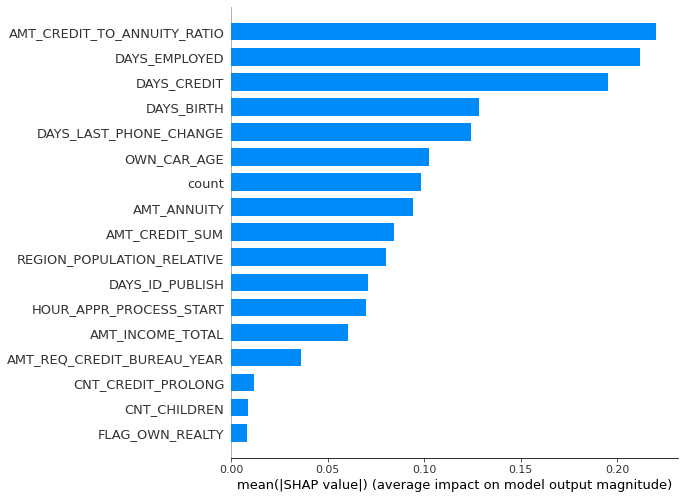

In [127]:
shap.summary_plot(shap_values, train[input_var], plot_type='bar')

* 시각화 결과 타겟값에 가장 큰 영향을 미치는 상위 5가지 변수는 아래와 같다.

'AMT_CREDIT_TO_ANNUITY_RATIO'  
'DAYS_EMPLOYED'   
'DAYS_CREDIT'  
'DAYS_BIRTH'  
'DAYS_LAST_PHONE_CHANGE'  


* 가장 영향력이 없는 변수는 아래와 같다.  

'CNT_CHILDREN'  
'FLAG_OWN_REALTY'  

* 아래에서 dependence plot으로 살펴봄.


## 2.5 영향을 많이 주는 상위 5개의 변수와 상환여부와의 관계

1. 'AMT_CREDIT_TO_ANNUITY_RATIO'  

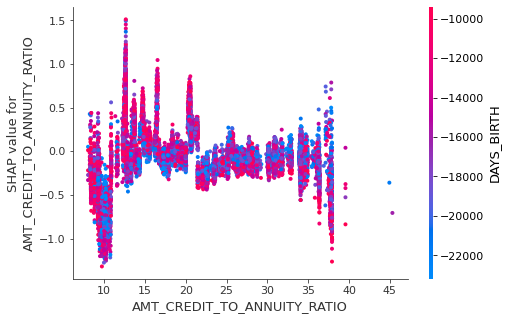

In [128]:
shap.dependence_plot('AMT_CREDIT_TO_ANNUITY_RATIO' , shap_values, train[input_var])

* 'AMT_CREDIT_TO_ANNUITY_RATIO'(돈을 갚아야할 개월수)가  12~20개월 이면 target값이 0보다 크므로돈을 못갚는 경우가 많다고 해석됨.

2. 'DAYS_EMPLOYED' 

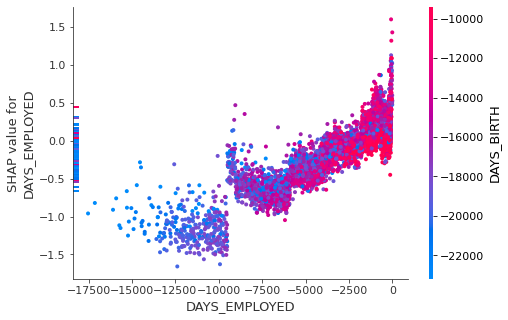

In [129]:
shap.dependence_plot('DAYS_EMPLOYED' , shap_values, train[input_var])

* 'DAYS_EMPLOYED'가 9000일 이상일때 대출상환확률이 급상승함.
* 취업한지 오래되면 대출 상환능력이 올라간다.

3. 'DAYS_CREDIT'  

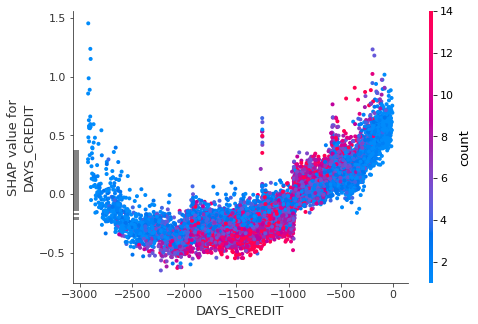

In [130]:
shap.dependence_plot('DAYS_CREDIT' , shap_values, train[input_var])

* 'DAYS_CREDIT'이 -3000 ~ -2000일 까지는 대출상환능력 상승
* 그 이후부터는 하락

4. 'DAYS_BIRTH' 

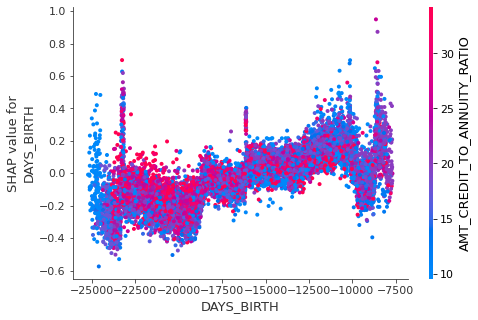

In [131]:
shap.dependence_plot('DAYS_BIRTH' , shap_values, train[input_var])

* 'DAYS_BIRTH'가 커질 수록(나이가 적을수록) 대출상환확률이 완만하게 감소함

5. 'DAYS_LAST_PHONE_CHANGE'  

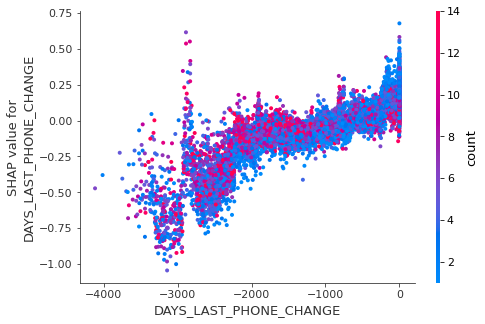

In [132]:
shap.dependence_plot('DAYS_LAST_PHONE_CHANGE' , shap_values, train[input_var])

* 'DAYS_LAST_PHONE_CHANGE'가 커질수록(폰을 최근에 바꿨을 수록) 대출상환확률에 낮아짐.

# 3. 결론
1. 대출 상환 기간이 상환여부에 가장 큰 영향을 준다. 해당 영향을 비선형적 관계이다(영향이 크다고 해서 인과관계가 있다고 단정짓긴 어렵다)<br><br>
2. 주택 보유 여부와 자식의 수는 대출 상환능력에 큰 영향을 미치지 않는다.<br><br>
3. 최근에 취업했을 수록, 최근에 대출을 받았을수록, 최근에 핸드폰을 바꿨을 수록, 나이가 어릴수록 대출금 상환 가능성이 낮다.<br>
(DAYS_EMPLOYED, DAYS_CREDIT, DAYS_LAST_PHONE_CHANGE, DAYS_BIRTH가 클수록 대출금 상환 가능성이 낮다)


## 3.1 마무리 시각화

In [136]:
# 상위25% 이내
group1 = train.loc[ (train['DAYS_EMPLOYED'].quantile(0.75) < train['DAYS_EMPLOYED']) &  
                    (train['DAYS_CREDIT'].quantile(0.75) < train['DAYS_CREDIT']) & 
                    (train['DAYS_LAST_PHONE_CHANGE'].quantile(0.75) < train['DAYS_LAST_PHONE_CHANGE']) &
                    (train['DAYS_EMPLOYED'].quantile(0.75) < train['DAYS_EMPLOYED']) &
                    (train['DAYS_BIRTH'].quantile(0.75) < train['DAYS_BIRTH'])  ]

In [137]:
# 하위25% 이하
group2 = train.loc[ (train['DAYS_EMPLOYED'].quantile(0.75) > train['DAYS_EMPLOYED']) &  
                    (train['DAYS_CREDIT'].quantile(0.75) > train['DAYS_CREDIT']) & 
                    (train['DAYS_LAST_PHONE_CHANGE'].quantile(0.75) > train['DAYS_LAST_PHONE_CHANGE']) &
                    (train['DAYS_EMPLOYED'].quantile(0.75) > train['DAYS_EMPLOYED']) &
                    (train['DAYS_BIRTH'].quantile(0.75) > train['DAYS_BIRTH'])  ]

In [139]:
# 시각화를 위해 df생성
group1['group'] = 1
group2['group'] = 0
full = pd.concat([group1,group2], axis=0)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [140]:
import seaborn as sns

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='group', ylabel='TARGET'>

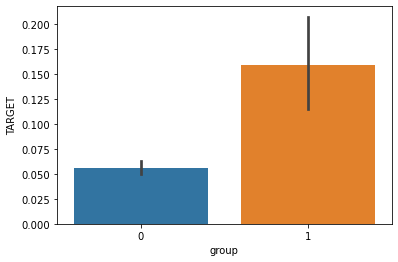

In [141]:
sns.barplot('group', 'TARGET', data=full)

* 상위 5개 모든변수의 25% 이내는 대출상환확률이 높고(group = 0), 상위 5개 모든변수의 75% 이하는 대출상환확률이 낮은 것을 시각화를 통해서도 확인할 수있다.(group = 1)
